In [ ]:
# ─────────────────────────────────────────────────────────────────────────────
# Cell: Train & Save GAN + Evaluate Generator Quality
# ─────────────────────────────────────────────────────────────────────────────
import os
import pickle
import numpy as np
import tensorflow as tf

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report

from tensorflow.keras import Input, Model
from tensorflow.keras.layers import (
    Conv1D, BatchNormalization, LeakyReLU, Flatten, Dense,
    Embedding, Concatenate, UpSampling1D, Activation, Reshape, Dropout
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import RandomNormal

# 1) Load & prepare IQ data
with open("RML2016.10a_dict.pkl", "rb") as f:
    raw = pickle.load(f, encoding="latin1")
X, y, snr = [], [], []
for (mod, S), sigs in raw.items():
    for sig in sigs:
        X.append(np.vstack([sig[0], sig[1]]).T)  # (128,2)
        y.append(mod)
        snr.append(S)
X = np.array(X, dtype=np.float32)
y = np.array(y)
snr = np.array(snr)

# 2) Encode labels & select high-SNR for GAN training
le      = LabelEncoder()
y_enc   = le.fit_transform(y)
mask    = snr > 6
X_train = X[mask]
y_train = y_enc[mask]
n_classes = len(le.classes_)

# 3) GAN definitions
def define_discriminator(inp_shape, n_classes):
    init = RandomNormal(0.02)
    inp  = Input(shape=inp_shape)
    x    = Conv1D(32,3,padding='same',kernel_initializer=init)(inp)
    x    = LeakyReLU(0.2)(x); x = Dropout(0.5)(x)
    x    = Conv1D(64,3,strides=2,padding='same',kernel_initializer=init)(x)
    x    = BatchNormalization()(x); x = LeakyReLU(0.2)(x); x = Dropout(0.5)(x)
    x    = Conv1D(128,3,strides=2,padding='same',kernel_initializer=init)(x)
    x    = BatchNormalization()(x); x = LeakyReLU(0.2)(x); x = Dropout(0.5)(x)
    x    = Flatten()(x)
    out_r   = Dense(1, activation='sigmoid', name='real_or_fake')(x)
    out_cls = Dense(n_classes, activation='softmax', name='modulation')(x)
    m    = Model(inp, [out_r, out_cls])
    m.compile(optimizer=Adam(1e-4, beta_1=0.5),
              loss=['binary_crossentropy','sparse_categorical_crossentropy'])
    return m

def define_generator(latent_dim, n_classes):
    init    = RandomNormal(0.02)
    in_lbl  = Input(shape=(1,))
    li      = Embedding(n_classes, 50)(in_lbl)
    li      = Dense(latent_dim, kernel_initializer=init)(li)
    li      = Reshape((latent_dim,))(li)
    in_noise= Input(shape=(latent_dim,))
    merge   = Concatenate()([in_noise, li])
    x       = Dense(64*32, kernel_initializer=init)(merge)
    x       = Activation('relu')(x)
    x       = Reshape((32,64))(x)
    x       = UpSampling1D()(x)
    x       = Conv1D(64,5,padding='same',kernel_initializer=init)(x)
    x       = BatchNormalization()(x); x=Activation('relu')(x)
    x       = UpSampling1D()(x)
    x       = Conv1D(32,5,padding='same',kernel_initializer=init)(x)
    x       = BatchNormalization()(x); x=Activation('relu')(x)
    x       = Conv1D(2,5,padding='same',kernel_initializer=init)(x)
    out     = Activation('tanh')(x)
    return Model([in_noise, in_lbl], out)

def define_gan(gen, disc):
    for layer in disc.layers:
        if not isinstance(layer, BatchNormalization):
            layer.trainable = False
    out = disc(gen.output)
    m   = Model(gen.input, out)
    m.compile(optimizer=Adam(1e-4, beta_1=0.5),
              loss=['binary_crossentropy','sparse_categorical_crossentropy'])
    return m

# 4) Instantiate models
latent_dim  = 100
disc        = define_discriminator((128,2), n_classes)
gen         = define_generator(latent_dim, n_classes)
gan_model   = define_gan(gen, disc)

# 5) Prepare tf.data.Dataset
bs    = 64
steps = max(1, len(X_train)//bs)
def gan_data_gen():
    while True:
        noise  = np.random.randn(bs, latent_dim).astype('float32')
        labels = np.random.randint(0, n_classes, bs).astype('int32')
        real_y = np.ones((bs,1), dtype='float32')
        yield (noise, labels), (real_y, labels)

dataset = tf.data.Dataset.from_generator(
    gan_data_gen,
    output_signature=(
        (tf.TensorSpec([None,latent_dim], tf.float32),
         tf.TensorSpec([None],         tf.int32)),
        (tf.TensorSpec([None,1],       tf.float32),
         tf.TensorSpec([None],         tf.int32))
    )
).prefetch(tf.data.AUTOTUNE)

# 6) Train GAN
history = gan_model.fit(
    dataset,
    steps_per_epoch=steps,
    epochs=100,
    verbose=1
)

# 7) Save the generator
os.makedirs("saved_models", exist_ok=True)
gen.save("saved_models/gan_generator.keras")
print("✅ GAN generator saved")

# ───────────────────────────────────────────────────────────
# 8) Evaluate GAN’s quality on held-out real samples
# ───────────────────────────────────────────────────────────
# Sample 10k real and 10k fake, compare discriminator outputs
N_eval = min(10000, len(X))
idx_real = np.random.choice(len(X), N_eval, replace=False)
Xr     = X[idx_real]
yr     = y_enc[idx_real]

# Generate fakes with same labels
noise_f = np.random.randn(N_eval, latent_dim).astype('float32')
labels_f= yr
Xf     = gen.predict([noise_f, labels_f], verbose=0)

# Discriminator predictions
r_pred, r_cls = disc.predict(Xr, verbose=0)
f_pred, f_cls = disc.predict(Xf, verbose=0)

# Metrics
cls_acc_real = accuracy_score(yr, np.argmax(r_cls, axis=1))
cls_acc_fake = accuracy_score(labels_f, np.argmax(f_cls, axis=1))
avg_realness_real = r_pred.mean()
avg_realness_fake = f_pred.mean()

print(f"\nDiscriminator on REAL samples →  class acc: {cls_acc_real:.4f}, avg realness: {avg_realness_real:.4f}")
print(f"Discriminator on FAKE samples →  class acc: {cls_acc_fake:.4f}, avg realness: {avg_realness_fake:.4f}")

# 9) Classification reports for fake
print("\nClassification Report on FAKE:")
print(classification_report(labels_f, np.argmax(f_cls, axis=1), target_names=le.classes_))


2063/2063 ━━━━━━━━━━━━━━━━━━━━ 2s 818us/step
6875/6875 ━━━━━━━━━━━━━━━━━━━━ 24s 3ms/step
Epoch 1/20
2063/2063 ━━━━━━━━━━━━━━━━━━━━ 21s 9ms/step - accuracy: 0.1296 - loss: 5.9570
Epoch 2/20
2063/2063 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - accuracy: 0.3483 - loss: 1.8970
Epoch 3/20
2063/2063 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - accuracy: 0.4876 - loss: 1.4342
Epoch 4/20
2063/2063 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - accuracy: 0.5236 - loss: 1.2953
Epoch 5/20
2063/2063 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - accuracy: 0.5390 - loss: 1.3389
Epoch 6/20
2063/2063 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - accuracy: 0.5699 - loss: 1.1648
Epoch 7/20
2063/2063 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - accuracy: 0.5843 - loss: 1.1051
Epoch 8/20
2063/2063 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - accuracy: 0.5854 - loss: 1.0947
Epoch 9/20
2063/2063 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - accuracy: 0.5752 - loss: 1.1335
Epoch 10/20
2063/2063 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - accuracy: 0.5622 - loss: 1.1775
Epoch 11/20
2063/206

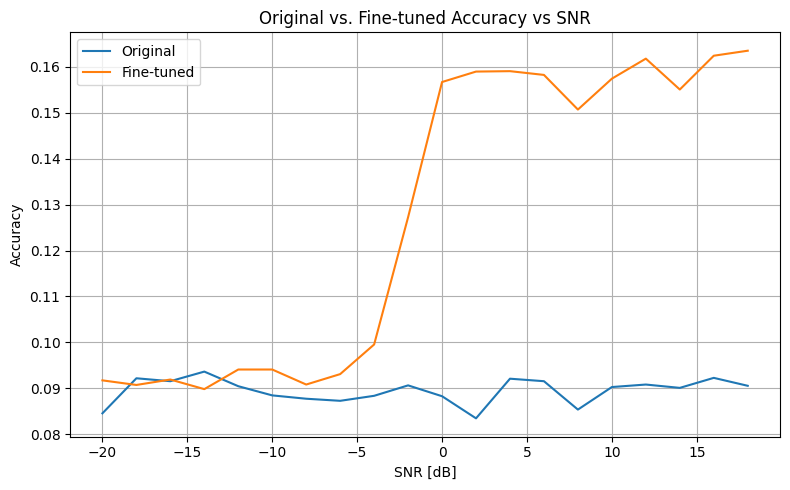

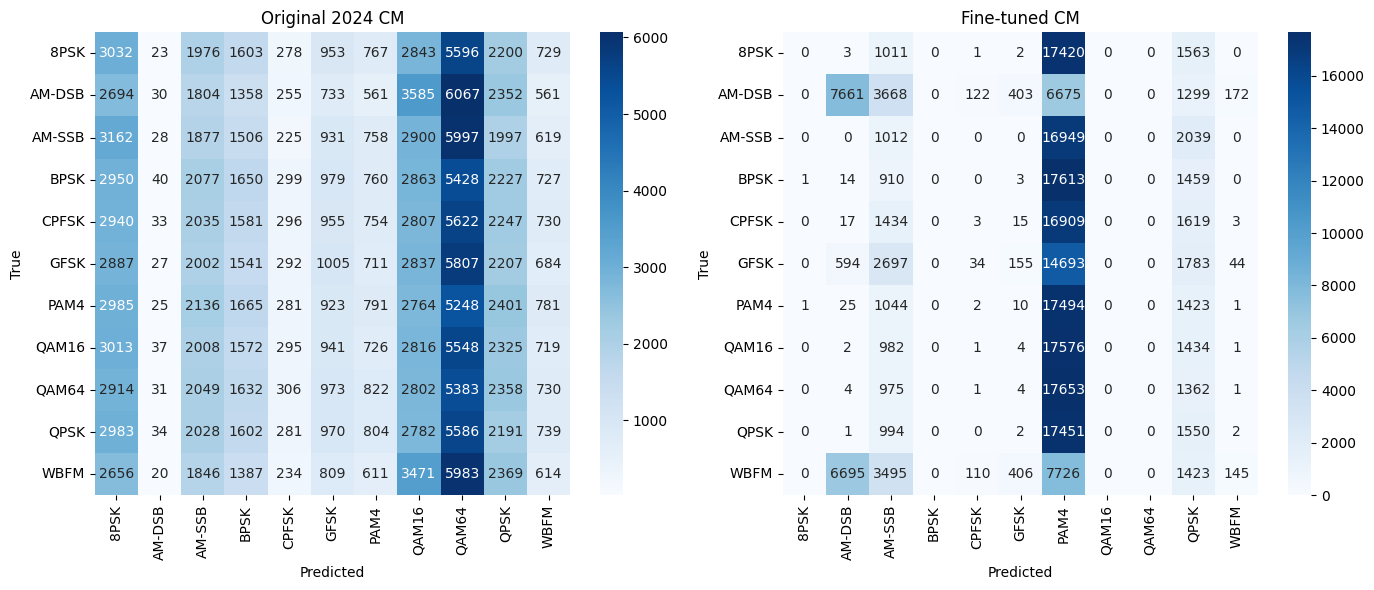

Original Report:
               precision    recall  f1-score   support

        8PSK       0.09      0.15      0.12     20000
      AM-DSB       0.09      0.00      0.00     20000
      AM-SSB       0.09      0.09      0.09     20000
        BPSK       0.10      0.08      0.09     20000
       CPFSK       0.10      0.01      0.03     20000
        GFSK       0.10      0.05      0.07     20000
        PAM4       0.10      0.04      0.06     20000
       QAM16       0.09      0.14      0.11     20000
       QAM64       0.09      0.27      0.13     20000
        QPSK       0.09      0.11      0.10     20000
        WBFM       0.08      0.03      0.04     20000

    accuracy                           0.09    220000
   macro avg       0.09      0.09      0.08    220000
weighted avg       0.09      0.09      0.08    220000

Fine‐tuned Report:
               precision    recall  f1-score   support

        8PSK       0.00      0.00      0.00     20000
      AM-DSB       0.51      0.38      0

/home/rameyjm7/.local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/rameyjm7/.local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/rameyjm7/.local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [5]:
# ─────────────────────────────────────────────────────────────────────────────
# Cell: Load GAN generator, fine‐tune 2024 LSTM, and compare
# ─────────────────────────────────────────────────────────────────────────────
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam

# 1) Reload IQ data & prepare splits
with open("RML2016.10a_dict.pkl", "rb") as f:
    raw = pickle.load(f, encoding="latin1")

X, y, snr = [], [], []
for (mod, S), sigs in raw.items():
    for sig in sigs:
        X.append(np.vstack([sig[0], sig[1]]).T)
        y.append(mod)
        snr.append(S)
X, y, snr = map(np.array, (X, y, snr))

le      = LabelEncoder()
y_enc   = le.fit_transform(y)
n_classes = len(le.classes_)

mask_train     = snr > 6
X_train_real   = X[mask_train]
y_train_real   = y_enc[mask_train]
X_test, y_test = X, y_enc
snr_test       = snr

# 2) Load GAN generator
gan_gen = load_model("saved_models/gan_generator.keras")

# 3) Synthesize new signals
latent_dim = gan_gen.input[0].shape[-1]
n_syn      = len(X_train_real)
noise      = np.random.randn(n_syn, latent_dim).astype('float32')
labels     = np.random.randint(0, n_classes, n_syn)
X_syn      = gan_gen.predict([noise, labels], verbose=1)
y_syn      = labels

# 4) Augment training set
X_aug = np.vstack([X_train_real, X_syn])
y_aug = np.concatenate([y_train_real, y_syn])
perm  = np.random.permutation(len(X_aug))
X_aug, y_aug = X_aug[perm], y_aug[perm]

# 5) Load original 2024 model
orig_model = load_model("lstm_rnn_2024.keras")

# 6) Evaluate original
y_orig = orig_model.predict(X_test, verbose=1).argmax(axis=1)
acc_orig = accuracy_score(y_test, y_orig)

# 7) Fine‐tune on augmented data
orig_model.compile(
    optimizer=Adam(1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
orig_model.fit(
    X_aug, y_aug,
    epochs=20,
    batch_size=64,
    verbose=1
)

# 8) Evaluate fine‐tuned
y_ft = orig_model.predict(X_test, verbose=1).argmax(axis=1)
acc_ft = accuracy_score(y_test, y_ft)

print(f"Original accuracy: {acc_orig:.4f}")
print(f"Fine‐tuned accuracy: {acc_ft:.4f}")

# 9) Plot Accuracy vs SNR
snrs = np.unique(snr_test)
acc_orig_snr = [accuracy_score(y_test[snr_test==s], y_orig[snr_test==s]) for s in snrs]
acc_ft_snr   = [accuracy_score(y_test[snr_test==s], y_ft[snr_test==s])   for s in snrs]

plt.figure(figsize=(8,5))
plt.plot(snrs, acc_orig_snr, label='Original')
plt.plot(snrs, acc_ft_snr,   label='Fine‐tuned')
plt.xlabel("SNR [dB]"); plt.ylabel("Accuracy")
plt.title("Original vs. Fine‐tuned Accuracy vs SNR")
plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()

# 10) Confusion matrices
cm_orig = confusion_matrix(y_test, y_orig)
cm_ft   = confusion_matrix(y_test, y_ft)

fig, axs = plt.subplots(1,2,figsize=(14,6))
sns.heatmap(cm_orig, annot=True, fmt="d", cmap="Blues",
            xticklabels=le.classes_, yticklabels=le.classes_, ax=axs[0])
axs[0].set_title("Original 2024 CM")
sns.heatmap(cm_ft, annot=True, fmt="d", cmap="Blues",
            xticklabels=le.classes_, yticklabels=le.classes_, ax=axs[1])
axs[1].set_title("Fine‐tuned CM")
for ax in axs:
    ax.set_xlabel("Predicted"); ax.set_ylabel("True")
plt.tight_layout(); plt.show()

# 11) Reports
print("Original Report:\n", classification_report(y_test, y_orig,  target_names=le.classes_))
print("Fine‐tuned Report:\n", classification_report(y_test, y_ft, target_names=le.classes_))


6875/6875 ━━━━━━━━━━━━━━━━━━━━ 24s 3ms/step
Overall accuracy on full RML2016.10a: 0.6651

Classification Report:

              precision    recall  f1-score   support

        8PSK       0.93      0.58      0.72     20000
      AM-DSB       0.58      0.71      0.64     20000
      AM-SSB       0.27      0.98      0.42     20000
        BPSK       0.95      0.64      0.77     20000
       CPFSK       0.96      0.62      0.75     20000
        GFSK       0.87      0.67      0.76     20000
        PAM4       0.98      0.71      0.83     20000
       QAM16       0.93      0.69      0.79     20000
       QAM64       0.93      0.79      0.86     20000
        QPSK       0.85      0.63      0.72     20000
        WBFM       0.84      0.27      0.41     20000

    accuracy                           0.67    220000
   macro avg       0.83      0.67      0.70    220000
weighted avg       0.83      0.67      0.70    220000



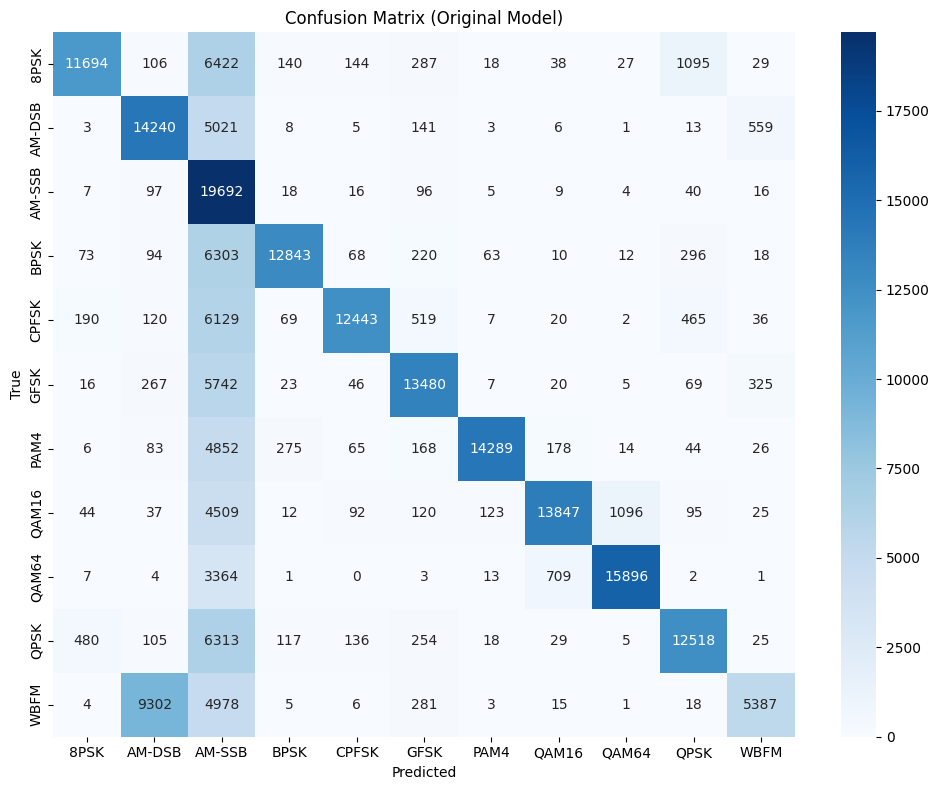

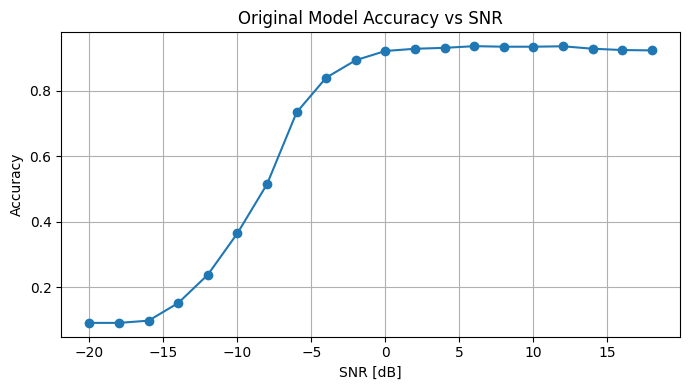

In [6]:
# ─────────────────────────────────────────────────────────────────────────────
# Cell: Evaluate Original 2024 LSTM on Full RML2016.10a Dataset
# ─────────────────────────────────────────────────────────────────────────────
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from tensorflow.keras.models import load_model

# 1) Load dataset
with open("RML2016.10a_dict.pkl", "rb") as f:
    data = pickle.load(f, encoding="latin1")

# 2) Prepare X (IQ+SNR), y, snr arrays
X_list, y_list, snr_list = [], [], []
for (mod, S), sigs in data.items():
    for sig in sigs:
        iq = np.vstack([sig[0], sig[1]]).T            # (128,2)
        s_col = np.full((iq.shape[0],1), S, dtype="float32")
        X_list.append(np.hstack([iq, s_col]))         # (128,3)
        y_list.append(mod)
        snr_list.append(S)

X_all   = np.array(X_list, dtype="float32")          # (N,128,3)
y_all   = np.array(y_list)
snr_all = np.array(snr_list)

# 3) Encode labels
le     = LabelEncoder()
y_enc  = le.fit_transform(y_all)
n_class= len(le.classes_)

# 4) Load the original 2024 model
model = load_model("lstm_rnn_2024.keras")

# 5) Predict on the full dataset
y_prob = model.predict(X_all, verbose=1)
y_pred = np.argmax(y_prob, axis=1)

# 6) Overall accuracy
acc_total = accuracy_score(y_enc, y_pred)
print(f"Overall accuracy on full RML2016.10a: {acc_total:.4f}\n")

# 7) Classification report
print("Classification Report:\n")
print(classification_report(y_enc, y_pred, target_names=le.classes_))

# 8) Confusion matrix
cm = confusion_matrix(y_enc, y_pred)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted"); plt.ylabel("True")
plt.title("Confusion Matrix (Original Model)")
plt.tight_layout(); plt.show()

# 9) Accuracy vs SNR
snr_values = np.unique(snr_all)
acc_per_snr = []
for S in snr_values:
    mask = snr_all == S
    acc_per_snr.append(accuracy_score(y_enc[mask], y_pred[mask]))

plt.figure(figsize=(7,4))
plt.plot(snr_values, acc_per_snr, marker="o")
plt.xlabel("SNR [dB]"); plt.ylabel("Accuracy")
plt.title("Original Model Accuracy vs SNR")
plt.grid(True); plt.tight_layout(); plt.show()


4125/4125 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step
Accuracy on SNR>-6: 0.9185



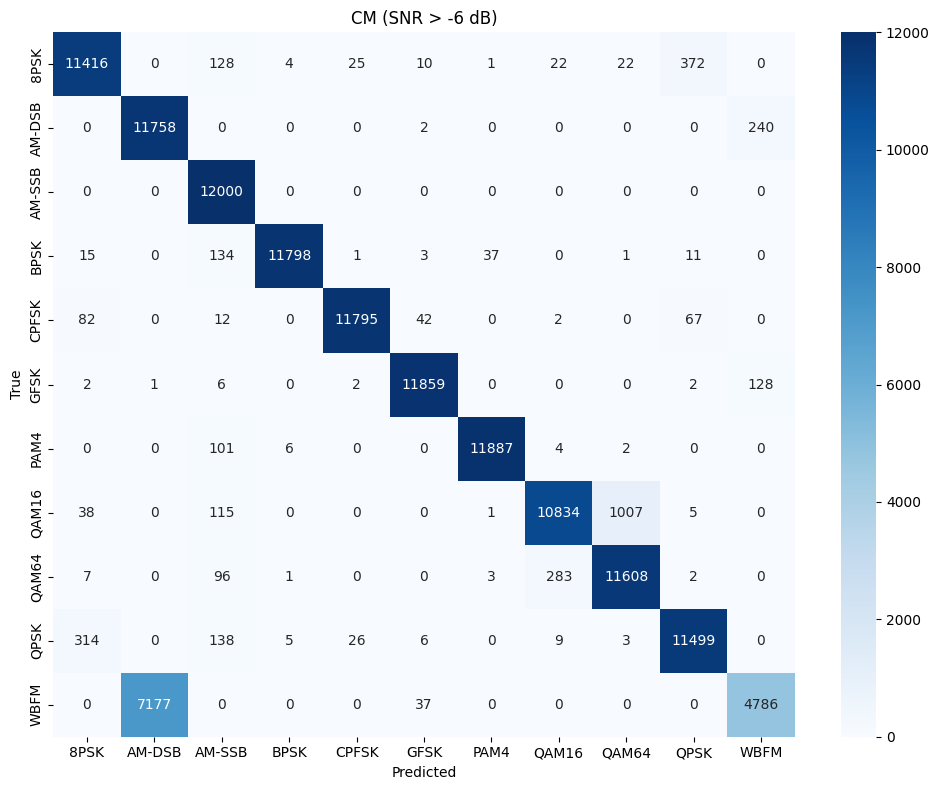

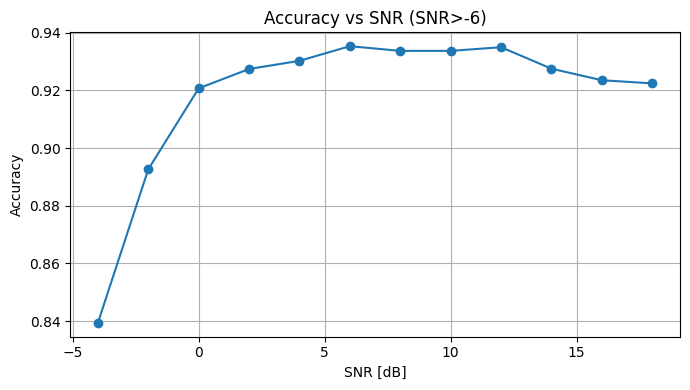

In [7]:
# ─────────────────────────────────────────────────────────────────────────────
# Cell: Evaluate original 2024 LSTM on RML2016 with IQ+SNR loaded correctly
# ─────────────────────────────────────────────────────────────────────────────
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from tensorflow.keras.models import load_model

# 1) Load the pickle
with open("RML2016.10a_dict.pkl","rb") as f:
    data = pickle.load(f, encoding="latin1")

# 2) Build X with IQ + SNR
X_list, y_list, snr_list = [], [], []
for (mod, S), sigs in data.items():
    for sig in sigs:
        iq      = np.vstack([sig[0], sig[1]]).T        # (128,2)
        s_col   = np.full((iq.shape[0],1), S, dtype=np.float32)
        X_list.append(np.hstack([iq, s_col]))          # → (128,3)
        y_list.append(mod)
        snr_list.append(S)

X_all   = np.array(X_list, dtype=np.float32)         # (N,128,3)
y_all   = np.array(y_list)
snr_all = np.array(snr_list)

# 3) Encode labels
le     = LabelEncoder()
y_enc  = le.fit_transform(y_all)

# 4) Load your 2024 model (expects (128,3) input)
model = load_model("lstm_rnn_2024.keras")

# 5) Predict on SNR > -6 only
mask = snr_all > -6
X_eval = X_all[mask]
y_eval = y_enc[mask]
snr_eval = snr_all[mask]

y_pred = model.predict(X_eval, verbose=1).argmax(axis=1)

# 6) Overall accuracy
acc = accuracy_score(y_eval, y_pred)
print(f"Accuracy on SNR>-6: {acc:.4f}\n")

# 7) Confusion matrix
cm = confusion_matrix(y_eval, y_pred)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("CM (SNR > -6 dB)")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.tight_layout(); plt.show()

# 8) Accuracy vs SNR
snr_vals = np.unique(snr_eval)
acc_snr = [accuracy_score(y_eval[snr_eval==s], y_pred[snr_eval==s])
           for s in snr_vals]

plt.figure(figsize=(7,4))
plt.plot(snr_vals, acc_snr, marker="o")
plt.xlabel("SNR [dB]"); plt.ylabel("Accuracy")
plt.title("Accuracy vs SNR (SNR>-6)")
plt.grid(True); plt.tight_layout(); plt.show()


In [ ]:
# ─────────────────────────────────────────────────────────────────────────────
# Cell: Train GAN (generator) via .fit with live progress (fixed structure)
# ─────────────────────────────────────────────────────────────────────────────
import pickle
import numpy as np
import tensorflow as tf

from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import (
    Conv1D, BatchNormalization, LeakyReLU, Flatten, Dense,
    Embedding, Concatenate, UpSampling1D, Activation, Reshape, Dropout
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import RandomNormal

# 1) Load & prepare IQ data
with open("RML2016.10a_dict.pkl","rb") as f:
    raw = pickle.load(f, encoding="latin1")
X_list, y_list = [], []
for (mod, S), sigs in raw.items():
    for sig in sigs:
        X_list.append(np.vstack([sig[0], sig[1]]).T)
X_iq = np.array(X_list, dtype=np.float32)

# 2) Label setup
y_all = [mod for (mod,_) , sigs in raw.items() for _ in sigs]
le    = LabelEncoder()
y_enc = le.fit_transform(y_all)
n_classes = len(le.classes_)

# 3) Define GAN components
def define_discriminator():
    init = RandomNormal(0.02)
    inp  = Input((128,2))
    x    = Conv1D(32,3,padding='same',kernel_initializer=init)(inp)
    x    = LeakyReLU(0.2)(x); x=Dropout(0.5)(x)
    x    = Conv1D(64,3,strides=2,padding='same',kernel_initializer=init)(x)
    x    = BatchNormalization()(x); x=LeakyReLU(0.2)(x); x=Dropout(0.5)(x)
    x    = Conv1D(128,3,strides=2,padding='same',kernel_initializer=init)(x)
    x    = BatchNormalization()(x); x=LeakyReLU(0.2)(x); x=Dropout(0.5)(x)
    x    = Flatten()(x)
    r    = Dense(1, activation='sigmoid')(x)
    c    = Dense(n_classes, activation='softmax')(x)
    m    = Model(inp, [r,c])
    m.compile(optimizer=Adam(1e-4, beta_1=0.5),
              loss=['binary_crossentropy','sparse_categorical_crossentropy'])
    return m

def define_generator(latent_dim):
    init = RandomNormal(0.02)
    in_lbl  = Input((1,))
    li      = Embedding(n_classes,50)(in_lbl)
    li      = Dense(latent_dim, kernel_initializer=init)(li)
    li      = Reshape((latent_dim,))(li)
    in_noise= Input((latent_dim,))
    merge   = Concatenate()([in_noise, li])
    x       = Dense(64*32, kernel_initializer=init)(merge)
    x       = Activation('relu')(x)
    x       = Reshape((32,64))(x)
    x       = UpSampling1D()(x)
    x       = Conv1D(64,5,padding='same',kernel_initializer=init)(x)
    x       = BatchNormalization()(x); x=Activation('relu')(x)
    x       = UpSampling1D()(x)
    x       = Conv1D(32,5,padding='same',kernel_initializer=init)(x)
    x       = BatchNormalization()(x); x=Activation('relu')(x)
    x       = Conv1D(2,5,padding='same',kernel_initializer=init)(x)
    out     = Activation('tanh')(x)
    return Model([in_noise,in_lbl], out)

def define_gan(gen, disc):
    for l in disc.layers:
        if not isinstance(l, BatchNormalization):
            l.trainable=False
    out = disc(gen.output)
    m   = Model(gen.input, out)
    m.compile(optimizer=Adam(1e-4, beta_1=0.5),
              loss=['binary_crossentropy','sparse_categorical_crossentropy'])
    return m

disc       = define_discriminator()
latent_dim = 100
gen        = define_generator(latent_dim)
gan_model  = define_gan(gen, disc)

# 4) Build tf.data.Dataset with correct tuple structure
bs    = 64
steps = max(1, len(X_iq)//bs)

def gen_data():
    while True:
        noise  = np.random.randn(bs, latent_dim).astype('float32')
        labels = np.random.randint(0, n_classes, size=(bs,))
        # MUST yield tuples, not lists:
        yield (noise, labels), (np.ones((bs,1), dtype='float32'), labels)

dataset = tf.data.Dataset.from_generator(
    gen_data,
    output_signature=(
        (tf.TensorSpec((None,latent_dim), tf.float32),
         tf.TensorSpec((None,),          tf.int32)),
        (tf.TensorSpec((None,1),         tf.float32),
         tf.TensorSpec((None,),          tf.int32))
    )
).prefetch(tf.data.AUTOTUNE)

# 5) Train GAN (generator) via .fit and watch live progress
history = gan_model.fit(
    dataset,
    steps_per_epoch=steps,
    epochs=500,
    verbose=1
)

# 6) Save the trained generator
import os
os.makedirs("saved_models", exist_ok=True)
gen.save("saved_models/gan_generator_live.keras")
print("✅ GAN generator saved to saved_models/gan_generator_live.keras")


Epoch 1/500
3437/3437 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - functional_44_loss: 2.1700 - loss: 2.6965
Epoch 2/500
3437/3437 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - functional_44_loss: 0.3188 - loss: 0.3928
Epoch 3/500
3437/3437 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - functional_44_loss: 0.1022 - loss: 0.1264
Epoch 4/500
3437/3437 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - functional_44_loss: 0.0388 - loss: 0.0488
Epoch 5/500
3437/3437 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - functional_44_loss: 0.0198 - loss: 0.0248
Epoch 6/500
3437/3437 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - functional_44_loss: 0.0113 - loss: 0.0142
Epoch 7/500
3437/3437 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - functional_44_loss: 0.0073 - loss: 0.0093
Epoch 8/500
3437/3437 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - functional_44_loss: 0.0056 - loss: 0.0071
Epoch 9/500
3437/3437 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - functional_44_loss: 0.0042 - loss: 0.0053
Epoch 10/500
3437/3437 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - functional_44_loss: 0.0035 - loss: 0.0045
Epoch 11/

In [ ]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam

# 1) Reload full RML2016 IQ+SNR dataset
with open("RML2016.10a_dict.pkl", "rb") as f:
    data = pickle.load(f, encoding="latin1")

X_list, y_list, snr_list = [], [], []
for (mod, S), sigs in data.items():
    for sig in sigs:
        iq    = np.vstack([sig[0], sig[1]]).T        # (128,2)
        s_col = np.full((128,1), S, dtype=np.float32)
        X_list.append(np.hstack([iq, s_col]))       # → (128,3)
        y_list.append(mod)
        snr_list.append(S)

X_all   = np.array(X_list, dtype=np.float32)
y_all   = np.array(y_list)
snr_all = np.array(snr_list)

# 2) Encode labels
le       = LabelEncoder()
y_enc    = le.fit_transform(y_all)
n_classes = len(le.classes_)

# 3) Load trained GAN generator
gan_gen = load_model("saved_models/gan_generator_live.keras")

# 4) Synthesize same number of samples as real
N = X_all.shape[0]
latent_dim = gan_gen.input[0].shape[-1]
noise  = np.random.randn(N, latent_dim).astype("float32")
labels = np.random.randint(0, n_classes, size=(N,))
iq_syn = gan_gen.predict([noise, labels], verbose=1)

# 5) Reattach SNR channel
snr_chan = snr_all[:, None, None].astype("float32")
snr_chan = np.broadcast_to(snr_chan, (N, 128, 1))
X_syn    = np.concatenate([iq_syn, snr_chan], axis=-1)

# 6) Prepare real-only and augmented datasets
X_real, y_real = X_all, y_enc
X_aug = np.vstack([X_real, X_syn])
y_aug = np.concatenate([y_real, y_enc])

# shuffle augmented
perm = np.random.permutation(len(X_aug))
X_aug, y_aug = X_aug[perm], y_aug[perm]

# 7) Load two fresh copies of original LSTM for fine-tuning
real_ft = load_model("lstm_rnn_2024.keras")
aug_ft  = load_model("lstm_rnn_2024.keras")

# recompile to ensure training mode
for m in (real_ft, aug_ft):
    m.compile(optimizer=Adam(1e-4),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# 8) Fine-tune on real-only for 10 epochs
real_ft.fit(X_real, y_real, epochs=10, batch_size=64, verbose=1)
y_real_pred = real_ft.predict(X_all, verbose=1).argmax(axis=1)
acc_real = accuracy_score(y_enc, y_real_pred)

# 9) Fine-tune on GAN+real for 10 epochs
aug_ft.fit(X_aug, y_aug, epochs=10, batch_size=64, verbose=1)
y_aug_pred = aug_ft.predict(X_all, verbose=1).argmax(axis=1)
acc_aug = accuracy_score(y_enc, y_aug_pred)

print(f"\nReal-only fine-tuned accuracy: {acc_real:.4f}")
print(f"GAN+Real  fine-tuned accuracy: {acc_aug:.4f}")

# 10) Plot Accuracy vs SNR comparison
snr_vals = np.unique(snr_all)
acc_real_snr = [accuracy_score(y_enc[snr_all==s], y_real_pred[snr_all==s]) for s in snr_vals]
acc_aug_snr  = [accuracy_score(y_enc[snr_all==s], y_aug_pred[snr_all==s])  for s in snr_vals]

plt.figure(figsize=(8,5))
plt.plot(snr_vals, acc_real_snr, label='Real-only FT')
plt.plot(snr_vals, acc_aug_snr,  label='GAN+Real FT')
plt.xlabel("SNR [dB]"); plt.ylabel("Accuracy")
plt.title("Fine‑tuned Accuracy vs SNR")
plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()

# 11) Confusion Matrices and Reports
for title, preds in [("Real-only FT", y_real_pred), ("GAN+Real FT", y_aug_pred)]:
    cm = confusion_matrix(y_enc, preds)
    plt.figure(figsize=(10,8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title(f"{title} Confusion Matrix")
    plt.xlabel("Predicted"); plt.ylabel("True")
    plt.tight_layout(); plt.show()
    print(f"\n{title} Classification Report:\n",
          classification_report(y_enc, preds, target_names=le.classes_))

